In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# PyTorch와 Detectron2를 설치
!pip install torch torchvision torchaudio
!pip install pyyaml

# Detectron2 설치 (CUDA 버전에 맞게 설치)
!pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-pwqnh6hr
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-pwqnh6hr
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb
  Preparing metadata (setup.py) ... done


In [3]:
# Roboflow에서 데이터셋을 다운로드
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="F7n0xBc4DlxgFEFkMS8V")
project = rf.workspace("ajou-univ-hgucx").project("compare-ybgrk")
version = project.version(5)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to compare-5 in coco:: 100%|██████████| 463/463 [00:00<00:00, 3876.10it/s]


In [15]:
# @title Catalog 초기화 필요시
DatasetCatalog.clear()
MetadataCatalog.clear()

In [16]:
# Detectron2 설치 확인
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# 필요 패키지 불러오기
import os
import numpy as np
import cv2
import random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.data.datasets import register_coco_instances

# COCO 데이터셋 등록
train_json_path = dataset.location + "/train/_annotations.coco.json"
val_json_path = dataset.location + "/valid/_annotations.coco.json"
train_image_dir = dataset.location + "/train"
val_image_dir = dataset.location + "/valid"

# 학습 및 검증 데이터셋 등록
register_coco_instances("train_dataset", {}, train_json_path, train_image_dir)
register_coco_instances("val_dataset", {}, val_json_path, val_image_dir)

# 데이터셋 메타데이터 가져오기
train_metadata = MetadataCatalog.get("train_dataset")
val_metadata = MetadataCatalog.get("val_dataset")


In [14]:
classes = ["GrowingMush", "GrownMush"]

# train_dataset의 thing_classes 수동 설정
MetadataCatalog.get("train_dataset").thing_classes = classes
MetadataCatalog.get("val_dataset").thing_classes = classes

AssertionError: Attribute 'thing_classes' in the metadata of 'val_dataset' cannot be set to a different value!
['mush', 'GrowingMush', 'GrownMush'] != ['GrowingMush', 'GrownMush']

In [18]:
import json

def remove_class_from_coco(json_file, class_to_remove):
    # Load the JSON file
    with open(json_file, 'r') as file:
        data = json.load(file)

    # Get the list of categories
    categories = data['categories']
    annotations = data['annotations']

    # Identify the id of the class to remove
    class_ids_to_remove = [cat['id'] for cat in categories if cat['name'] == class_to_remove]

    if not class_ids_to_remove:
        raise ValueError(f"Class '{class_to_remove}' not found in dataset")

    class_id_to_remove = class_ids_to_remove[0]

    # Remove the class from categories
    categories = [cat for cat in categories if cat['id'] != class_id_to_remove]

    # Remove the annotations of the removed class
    annotations = [ann for ann in annotations if ann['category_id'] != class_id_to_remove]

    # Save the updated JSON
    with open(json_file, 'w') as file:
        json.dump(data, file, indent=2)

    print(f"Removed class '{class_to_remove}' from the dataset.")

# Specify the JSON file and class to remove
json_file_path = train_json_path
class_to_remove = 'mush'

remove_class_from_coco(json_file_path, class_to_remove)

Removed class 'mush' from the dataset.


WARNING [09/11 14:00:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/11 14:00:14 d2.data.datasets.coco]: Loaded 39 images in COCO format from /content/compare-5/valid/_annotations.coco.json


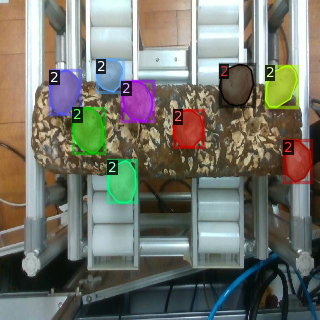

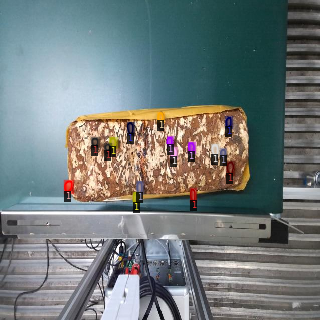

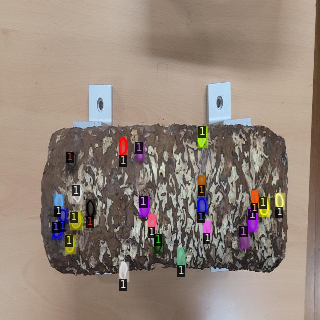

In [19]:
from google.colab.patches import cv2_imshow

#visualize training data
dataset_train_metadata = MetadataCatalog.get("train_dataset")
dataset_dicts = DatasetCatalog.get("val_dataset")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [20]:
import os
import torch
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

class EarlyStoppingTrainer(DefaultTrainer):
    def __init__(self, cfg, patience=3, min_delta=0.001):
        super().__init__(cfg)
        self.patience = patience  # 개선이 없을 때 멈추기 전 최대 대기 횟수
        self.min_delta = min_delta  # 성능 개선 최소 변화량
        self.best_score = None  # 최고 성능 점수 저장
        self.counter = 0  # 대기 횟수 카운터

    def run_step(self):
        super().run_step()

        # 매 EVAL_PERIOD마다 검증
        if self.iter % self.cfg.TEST.EVAL_PERIOD == 0 and self.iter != 0:
            # 검증 데이터셋 로더 및 평가자 설정
            val_loader = build_detection_test_loader(self.cfg, "val_dataset")
            evaluator = COCOEvaluator("val_dataset", self.cfg, True, output_dir="./output")
            results = inference_on_dataset(self.model, val_loader, evaluator)

            # 현재 성능(mAP)을 기록
            current_score = results["bbox"]["AP"]  # mAP 값을 사용
            print(f"Validation mAP at iteration {self.iter}: {current_score}")

            # Early Stopping 로직
            if self.best_score is None or current_score > self.best_score + self.min_delta:
                # 성능이 개선되면 best_score 업데이트
                self.best_score = current_score
                self.counter = 0  # 개선되면 대기 횟수 초기화
            else:
                # 성능이 개선되지 않으면 대기 횟수 증가
                self.counter += 1
                print(f"No improvement for {self.counter} consecutive evals.")

                # 개선이 없으면 학습 중단
                if self.counter >= self.patience:
                    print("Early stopping triggered. Stopping training.")
                    raise StopIteration  # 학습을 중단

In [23]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

# Config 설정
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
# 데이터셋 및 기타 설정
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = ("val_dataset",)
cfg.DATALOADER.NUM_WORKERS = 8

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # 학습된 가중치

# 모델 출력 경로 설정
cfg.OUTPUT_DIR = "./output"

# 학습 하이퍼파라미터
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.025  # 학습률 설정
cfg.SOLVER.MAX_ITER = 9000  # 학습 iteration 수
# 학습률 스케줄러 설정 (예: 500 iter와 800 iter에서 학습률을 감소)
cfg.SOLVER.STEPS = [i for i in range(500, 8500, 500)]
cfg.SOLVER.GAMMA = 0.1  # 학습률 감소 비율
cfg.SOLVER.WEIGHT_DECAY = 0.0001  # weight_decay 설정

# 매 200 iteration마다 validation을 수행
cfg.TEST.EVAL_PERIOD = 500

# 모델 구성 후 학습
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 클래스 수 설정

# 검증 시 사용될 평가자 설정
evaluator = COCOEvaluator("val_dataset", cfg, True, output_dir="./output")

# 학습 시작
trainer = EarlyStoppingTrainer(cfg, patience=3, min_delta=0.001)
trainer.resume_or_load(resume=False)

# Periodic validation 사용
trainer.train()

WARNING [09/11 14:10:10 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/11 14:10:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
 

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[09/11 14:10:11 d2.engine.train_loop]: Starting training from iteration 0


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[09/11 14:10:14 d2.utils.events]:  eta: 0:20:21  iter: 19  total_loss: 2.685  loss_cls: 1.284  loss_box_reg: 0.2689  loss_rpn_cls: 1.035  loss_rpn_loc: 0.1709    time: 0.1361  last_time: 0.1314  data_time: 0.0245  last_data_time: 0.0081   lr: 2.9275e-05  max_mem: 3180M
[09/11 14:10:16 d2.utils.events]:  eta: 0:20:08  iter: 39  total_loss: 1.626  loss_cls: 0.9565  loss_box_reg: 0.2467  loss_rpn_cls: 0.2957  loss_rpn_loc: 0.1632    time: 0.1343  last_time: 0.1267  data_time: 0.0083  last_data_time: 0.0076   lr: 3.3775e-05  max_mem: 3181M
[09/11 14:10:19 d2.utils.events]:  eta: 0:20:04  iter: 59  total_loss: 1.109  loss_cls: 0.6089  loss_box_reg: 0.2187  loss_rpn_cls: 0.1339  loss_rpn_loc: 0.08926    time: 0.1342  last_time: 0.1314  data_time: 0.0082  last_data_time: 0.0082   lr: 3.8275e-05  max_mem: 3181M
[09/11 14:10:22 d2.utils.events]:  eta: 0:20:02  iter: 79  total_loss: 1.01  loss_cls: 0.4288  loss_box_reg: 0.2802  loss_rpn_cls: 0.1501  loss_rpn_loc: 0.1026    time: 0.1337  last_tim

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[09/11 14:11:18 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0009 s/iter. Inference: 0.0292 s/iter. Eval: 0.0004 s/iter. Total: 0.0305 s/iter. ETA=0:00:00
[09/11 14:11:19 d2.evaluation.evaluator]: Total inference time: 0:00:00.995060 (0.029266 s / iter per device, on 1 devices)
[09/11 14:11:19 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.026097 s / iter per device, on 1 devices)
[09/11 14:11:19 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/11 14:11:19 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[09/11 14:11:19 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/11 14:11:19 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/11 14:11:19 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.03 seconds.
[09/11 14:11:19 d2.evaluation.

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[09/11 14:12:26 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0011 s/iter. Inference: 0.0268 s/iter. Eval: 0.0003 s/iter. Total: 0.0283 s/iter. ETA=0:00:00
[09/11 14:12:27 d2.evaluation.evaluator]: Total inference time: 0:00:00.988245 (0.029066 s / iter per device, on 1 devices)
[09/11 14:12:27 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.025876 s / iter per device, on 1 devices)
[09/11 14:12:27 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/11 14:12:27 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[09/11 14:12:27 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.36s)
creating index...
index created!
[09/11 14:12:27 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/11 14:12:27 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.02 seconds.
[09/11 14:12:27 d2.evaluation.

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[09/11 14:13:35 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0010 s/iter. Inference: 0.0262 s/iter. Eval: 0.0003 s/iter. Total: 0.0275 s/iter. ETA=0:00:00
[09/11 14:13:36 d2.evaluation.evaluator]: Total inference time: 0:00:00.942010 (0.027706 s / iter per device, on 1 devices)
[09/11 14:13:36 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.024592 s / iter per device, on 1 devices)
[09/11 14:13:36 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/11 14:13:36 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[09/11 14:13:36 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/11 14:13:36 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/11 14:13:36 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[09/11 14:13:36 d2.evaluation.

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[09/11 14:14:43 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0013 s/iter. Inference: 0.0259 s/iter. Eval: 0.0003 s/iter. Total: 0.0275 s/iter. ETA=0:00:00
[09/11 14:14:44 d2.evaluation.evaluator]: Total inference time: 0:00:00.982024 (0.028883 s / iter per device, on 1 devices)
[09/11 14:14:44 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.025760 s / iter per device, on 1 devices)
[09/11 14:14:44 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/11 14:14:44 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[09/11 14:14:44 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/11 14:14:44 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/11 14:14:44 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.02 seconds.
[09/11 14:14:44 d2.evaluation.

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[09/11 14:15:51 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0011 s/iter. Inference: 0.0266 s/iter. Eval: 0.0003 s/iter. Total: 0.0279 s/iter. ETA=0:00:00
[09/11 14:15:52 d2.evaluation.evaluator]: Total inference time: 0:00:00.972149 (0.028593 s / iter per device, on 1 devices)
[09/11 14:15:52 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.025481 s / iter per device, on 1 devices)
[09/11 14:15:52 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/11 14:15:52 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[09/11 14:15:52 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/11 14:15:52 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/11 14:15:52 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[09/11 14:15:52 d2.evaluation.

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[09/11 14:17:00 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0011 s/iter. Inference: 0.0257 s/iter. Eval: 0.0003 s/iter. Total: 0.0272 s/iter. ETA=0:00:00
[09/11 14:17:01 d2.evaluation.evaluator]: Total inference time: 0:00:00.962697 (0.028315 s / iter per device, on 1 devices)
[09/11 14:17:01 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.025221 s / iter per device, on 1 devices)
[09/11 14:17:01 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/11 14:17:01 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[09/11 14:17:01 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/11 14:17:01 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/11 14:17:01 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[09/11 14:17:01 d2.evaluation.

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[09/11 14:18:08 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0013 s/iter. Inference: 0.0258 s/iter. Eval: 0.0003 s/iter. Total: 0.0274 s/iter. ETA=0:00:00
[09/11 14:18:09 d2.evaluation.evaluator]: Total inference time: 0:00:00.949329 (0.027921 s / iter per device, on 1 devices)
[09/11 14:18:09 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.024941 s / iter per device, on 1 devices)
[09/11 14:18:09 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/11 14:18:09 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[09/11 14:18:09 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/11 14:18:09 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/11 14:18:09 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[09/11 14:18:09 d2.evaluation.

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[09/11 14:19:17 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0009 s/iter. Inference: 0.0274 s/iter. Eval: 0.0003 s/iter. Total: 0.0287 s/iter. ETA=0:00:00
[09/11 14:19:18 d2.evaluation.evaluator]: Total inference time: 0:00:00.976529 (0.028721 s / iter per device, on 1 devices)
[09/11 14:19:18 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.025560 s / iter per device, on 1 devices)
[09/11 14:19:18 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/11 14:19:18 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[09/11 14:19:18 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/11 14:19:18 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/11 14:19:18 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[09/11 14:19:18 d2.evaluation.

StopIteration: 